In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from dotenv import load_dotenv, find_dotenv
from pathlib import Path
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler

from src.data import FimacDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# find .env automagically by walking up directories until it's found
dotenv_path = find_dotenv()
project_dir = Path(dotenv_path).parent

# load up the entries as environment variables
load_dotenv(dotenv_path)

True

# Data loading

In [3]:
dataset = FimacDataset(project_dir/'data/interim/renders.hdf5')
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Network definition

In [4]:
from src.models import TestNet

net = TestNet().to(device)
net

TestNet(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc1): Linear(in_features=1048576, out_features=128, bias=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
)

# Training loop

In [5]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
criterion = nn.L1Loss()
scaler = GradScaler()

losses = list()
running_losses = list()


epochs = 5
net.train()

for epoch in range(epochs):
    running_loss = 0
    for i, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()

        X = X.to(device)
        y = y.to(device)

        with autocast():
            y_hat = net(X)
            loss = criterion(y_hat.squeeze(), y.type(torch.float32))

        scaler.scale(loss).backward()

        running_loss += loss.item()

        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())

        if i > 1000 / dataloader.batch_size:
            break
    running_losses.append(running_loss)

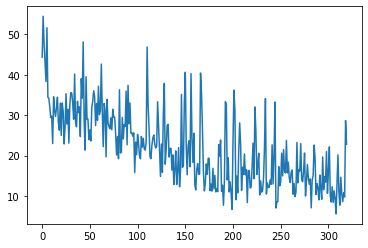

In [6]:
plt.plot(losses)
plt.show()

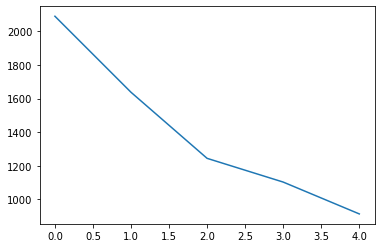

In [7]:
plt.plot(running_losses)
plt.show()